In [1]:
import json
import pandas as pd
from pathlib import Path

# Load NSLT-100
with open("../../data/annotations/nslt_100.json", "r") as f:
    nslt_data = json.load(f)

nslt_df = pd.DataFrame.from_dict(nslt_data, orient="index")
nslt_df[["class_id", "start_frame", "end_frame"]] = pd.DataFrame(
    nslt_df["action"].tolist(), index=nslt_df.index
)
nslt_df.reset_index(inplace=True)
nslt_df.rename(columns={"index": "video_id"}, inplace=True)

# Load WLASL (for bboxes)
with open("../../data/annotations/WLASL_v0.3.json", "r") as f:
    wlasl_data = json.load(f)
wlasl_data = pd.json_normalize(wlasl_data, record_path='instances', meta='gloss')

wlasl_df = pd.DataFrame(wlasl_data)
wlasl_df = wlasl_df[["video_id", "bbox"]]

# Merge bbox into NSLT
df = nslt_df.merge(wlasl_df, on="video_id", how="left")

# Drop videos with missing bbox
df = df.dropna(subset=["bbox"]).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2038 entries, 0 to 2037
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   video_id     2038 non-null   object
 1   subset       2038 non-null   object
 2   action       2038 non-null   object
 3   class_id     2038 non-null   int64 
 4   start_frame  2038 non-null   int64 
 5   end_frame    2038 non-null   int64 
 6   bbox         2038 non-null   object
dtypes: int64(3), object(4)
memory usage: 111.6+ KB


as for getting the BBOXES for the videos we will get the info from the main dataset 

In [2]:
import cv2

def load_and_trim_video(video_path, start_frame, end_frame):
    cap = cv2.VideoCapture(str(video_path))
    frames = []

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    end_frame = min(end_frame, total_frames - 1)

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    for _ in range(start_frame, end_frame):
        ret, frame = cap.read()
        if not ret:
            break
        frames.append(frame)

    cap.release()
    return frames


In [3]:
import numpy as np

def uniform_sample_frames(frames, T=32):
    if len(frames) == 0:
        return None

    if len(frames) >= T:
        idxs = np.linspace(0, len(frames) - 1, T).astype(int)
        return [frames[i] for i in idxs]
    else:
        # Pad by repeating last frame
        pad = [frames[-1]] * (T - len(frames))
        return frames + pad


In [4]:
def crop_frames_with_bbox(frames, bbox, margin=0.05):
    x1, y1, x2, y2 = bbox
    cropped = []

    for frame in frames:
        h, w, _ = frame.shape

        dx = int((x2 - x1) * margin)
        dy = int((y2 - y1) * margin)

        cx1 = max(0, x1 - dx)
        cy1 = max(0, y1 - dy)
        cx2 = min(w, x2 + dx)
        cy2 = min(h, y2 + dy)

        crop = frame[cy1:cy2, cx1:cx2]
        if crop.size == 0:
            return None

        cropped.append(crop)

    return cropped


In [5]:
def resize_and_grayscale(frames, size=112):
    processed = []
    for frame in frames:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (size, size))
        processed.append(resized)
    return processed


In [6]:
import torch

def stack_and_normalize(frames):
    tensor = torch.tensor(np.array(frames), dtype=torch.float32) / 255.0
    assert tensor.shape == (32, 112, 112)
    return tensor


In [7]:
def preprocess_sample(row, video_root, out_root):
    video_path = video_root / f"{row.video_id}.mp4"

    frames = load_and_trim_video(
        video_path,
        row.start_frame,
        row.end_frame
    )
    frames = uniform_sample_frames(frames, T=32)
    if frames is None:
        return False

    frames = crop_frames_with_bbox(frames, row.bbox)
    if frames is None:
        return False

    frames = resize_and_grayscale(frames)
    tensor = stack_and_normalize(frames)

    out_dir = out_root / row.subset
    out_dir.mkdir(parents=True, exist_ok=True)
    torch.save(tensor, out_dir / f"{row.video_id}.pt")

    return True


In [9]:
from tqdm import tqdm
from pathlib import Path

video_root = Path("../../data/raw_videos")
out_root = Path("../../data/processed")
i = 1
for _, row in df.iterrows():
    print(f"currently processing video {i}, video id: {row.video_id}")
    i+=1
    preprocess_sample(row, video_root, out_root)


currently processing video 1, video id: 05237
currently processing video 2, video id: 69422
currently processing video 3, video id: 10899
currently processing video 4, video id: 10898
currently processing video 5, video id: 10893
currently processing video 6, video id: 10892
currently processing video 7, video id: 10896
currently processing video 8, video id: 10895
currently processing video 9, video id: 10894
currently processing video 10, video id: 51069
currently processing video 11, video id: 51068
currently processing video 12, video id: 51064
currently processing video 13, video id: 51067
currently processing video 14, video id: 51066
currently processing video 15, video id: 51061
currently processing video 16, video id: 51060
currently processing video 17, video id: 66779
currently processing video 18, video id: 66778
currently processing video 19, video id: 65278
currently processing video 20, video id: 43180
currently processing video 21, video id: 06365
currently processing v

Building final dataset

In [10]:
df.head()

,video_id,subset,action,class_id,start_frame,end_frame,bbox
0,05237,train,"[77, 1, 55]",77,1,55,"[45, 10, 612, 480]"
1,69422,val,"[27, 1, 51]",27,1,51,"[363, 40, 871, 720]"
2,10899,train,"[82, 1, 48]",82,1,48,"[167, 9, 500, 360]"
3,10898,val,"[82, 1, 39]",82,1,39,"[73, 3, 221, 192]"
4,10893,train,"[82, 1, 50]",82,1,50,"[39, 3, 291, 240]"


In [11]:
# Create the tensor_path column
df['tensor_path'] = df.apply(
    lambda row: f"../../data/processed/{row['subset']}/{row['video_id']}.pt", 
    axis=1
)

# Display to verify
print(df[['video_id', 'subset', 'tensor_path']].head())

  video_id subset                          tensor_path
0    05237  train  ../../data/processed/train/05237.pt
1    69422    val    ../../data/processed/val/69422.pt
2    10899  train  ../../data/processed/train/10899.pt
3    10898    val    ../../data/processed/val/10898.pt
4    10893  train  ../../data/processed/train/10893.pt


In [12]:
df.head()

,video_id,subset,action,class_id,start_frame,end_frame,bbox,tensor_path
0,05237,train,"[77, 1, 55]",77,1,55,"[45, 10, 612, 480]",../../data/processed/train/05237.pt
1,69422,val,"[27, 1, 51]",27,1,51,"[363, 40, 871, 720]",../../data/processed/val/69422.pt
2,10899,train,"[82, 1, 48]",82,1,48,"[167, 9, 500, 360]",../../data/processed/train/10899.pt
3,10898,val,"[82, 1, 39]",82,1,39,"[73, 3, 221, 192]",../../data/processed/val/10898.pt
4,10893,train,"[82, 1, 50]",82,1,50,"[39, 3, 291, 240]",../../data/processed/train/10893.pt


/tmp/ipykernel_57339/4221263173.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='subset', palette='viridis', order=['train', 'val', 'test'])
/tmp/ipykernel_57339/4221263173.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_20.index.astype(str), y=top_20.values, palette='magma')


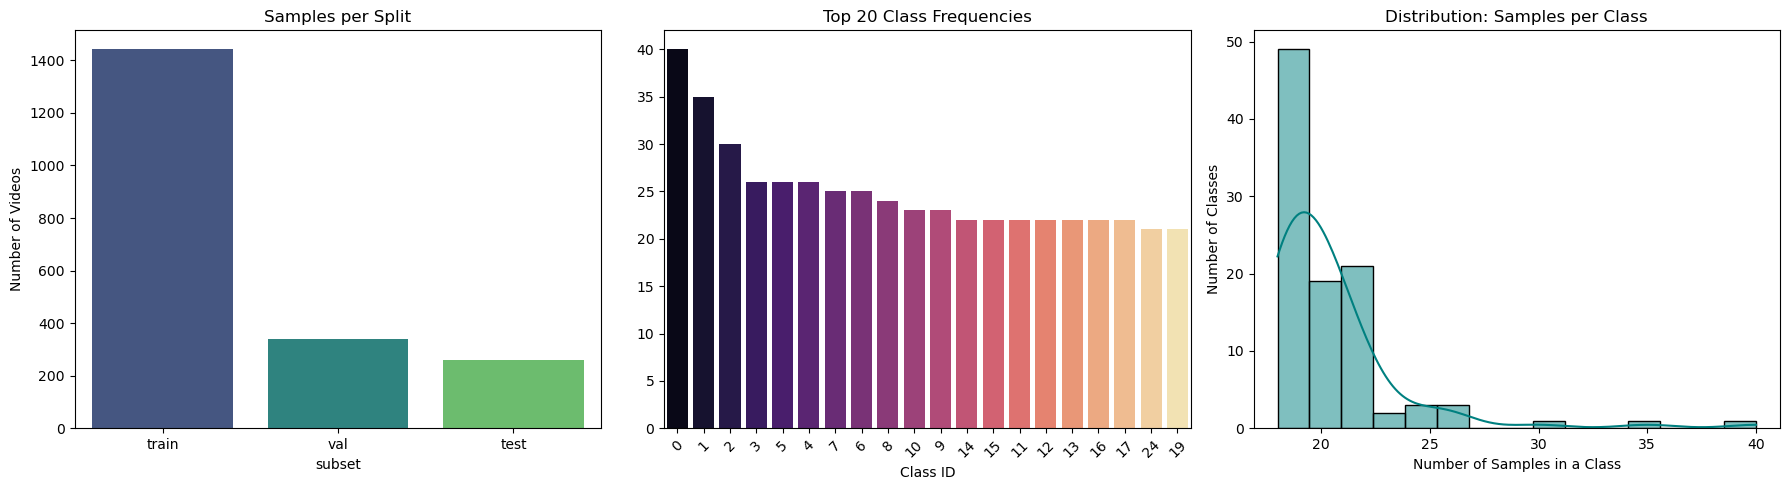

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

class_counts = df['class_id'].value_counts()

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=df, x='subset', palette='viridis', order=['train', 'val', 'test'])
plt.title('Samples per Split')
plt.ylabel('Number of Videos')

plt.subplot(1, 3, 2)
top_20 = class_counts.head(20)
sns.barplot(x=top_20.index.astype(str), y=top_20.values, palette='magma')
plt.xticks(rotation=45)
plt.title('Top 20 Class Frequencies')
plt.xlabel('Class ID')

plt.subplot(1, 3, 3)
sns.histplot(class_counts.values, bins=15, kde=True, color='teal')
plt.title('Distribution: Samples per Class')
plt.xlabel('Number of Samples in a Class')
plt.ylabel('Number of Classes')

plt.tight_layout()
plt.show()

from above plots it is visible that there is mild variability in the no of samples distribution among the each classes which we will keep intentionally to achieve real world distribution of the sign usually in use

as more the samples means the signs are more usually used and vice versa

so model shud learn less about the signs which are less likely used/available

In [14]:
df.to_csv('../../data/annotations/processed_wlsl_100.csv')